# Recreating MEIs, Explainable Variance, Model Performance

In [1]:
import os
import datajoint as dj
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nnfabrik.main import *
from nnfabrik.main import *
from nnvision.tables.from_mei import MEI, MEIShared, MEISeed, Method, Ensemble, SharedReadoutTrainedEnsembleModel, MethodGroup, MEIObjective, MEITargetUnits, MEITargetFunctions, MEITextures, MEIPrototype
from nnvision.tables.from_nnfabrik import TrainedModel
from nnfabrik.builder import get_data
from nnvision.tables.from_mei import MEI, Ensemble
from nnvision.tables.main import Recording
from nnvision.tables.ensemble_scores import CorrelationToAverageEnsembleScore
from nnvision.tables.scores import CorrelationToAverageScore
from nnvision.tables.measures import ExplainableVar
from nnvision.tables.bisc.main_fp_interface import RecordingInterfaceFP

Connecting kwilleke@134.76.19.44:3306


In [2]:
pop_key = {'model_fn': 'nnvision.models.convnext_core_shared_multihead_attention',
  'model_hash': '30aa56ea9f86f3e36c22bff83e6f4916',
  'dataset_fn': 'nnvision.datasets.monkey_loaders.monkey_static_loader_combined',
  'dataset_hash': 'e0dfed7743c7b8c6b1b0937003560ddd',
  'trainer_fn': 'nnvision.training.trainers.convnext_finetune_trainer',
  'trainer_hash': '05468e870191b8d65d7ee552e5fd9483',}
unit_keys = (RecordingInterfaceFP().Units & pop_key & dict(data_key_original="3783003058075", fp_proc_method=11)).fetch("unit_id", as_dict=True)
method_keys = dict(method_hash="f37ffdd11d23d4e7f33d867746f45db3")
ensemble_keys = [dict(ensemble_hash="edcaac8d7dfa97fceb0145fe88476300"),]
mei_key = dj.AndList([method_keys, ensemble_keys, "mei_seed=10", unit_keys])
unit_indices = ((MEI*RecordingInterfaceFP.Units) & mei_key & dict(data_key_original="3783003058075", fp_proc_method=11)).fetch("unit_index")

meis, id_used = ((MEI*RecordingInterfaceFP.Units) & mei_key & dict(data_key_original="3783003058075", fp_proc_method=11)).fetch("mei","unit_id_original", download_path="/data/fetched_from_attach", order_by="unit_id_original", )


In [3]:
all_ids = np.arange(1,257)
idx_filter = np.isin(all_ids, id_used)

In [4]:
r1, r2 = ((ExplainableVar.Units*CorrelationToAverageEnsembleScore.Units) & unit_keys & pop_key & dict(ensemble_hash="7f9b1a7bdb4293375801a1b06bb468be")).fetch("unit_fev","unit_avg_correlation")

In [5]:
fev_array = np.ones((16,16,))
n_plot=0
for i in range(256):
    if idx_filter[i]:
        fev_array[i//16, i%16] = r1[n_plot]
        n_plot +=1
    else:
        fev_array[i//16, i%16] = np.nan

(-0.5, 15.5, 15.5, -0.5)

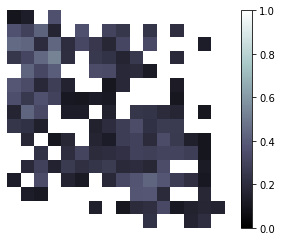

In [6]:
plt.imshow(fev_array, cmap="bone", vmin=0, vmax=1)
plt.colorbar()
plt.axis("off")
#plt.savefig("fev_spatial_bw.pdf")

In [8]:
corr_array = np.ones((16,16,))
n_plot=0
for i in range(256):
    if idx_filter[i]:
        corr_array[i//16, i%16] = r2[n_plot]
        n_plot +=1
    else:
        corr_array[i//16, i%16] = np.nan

(-0.5, 15.5, 15.5, -0.5)

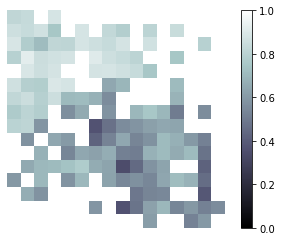

In [9]:
plt.imshow(corr_array, cmap="bone", vmin=0, vmax=1)
plt.colorbar()
plt.axis("off")
#plt.savefig("perf_spatial_bw.pdf")

In [11]:
def fix_mei(mei):
    mei = mei.transpose(1,2,0)
    mei = mei + np.abs(mei.min())
    mei = mei/mei.max()
    return mei


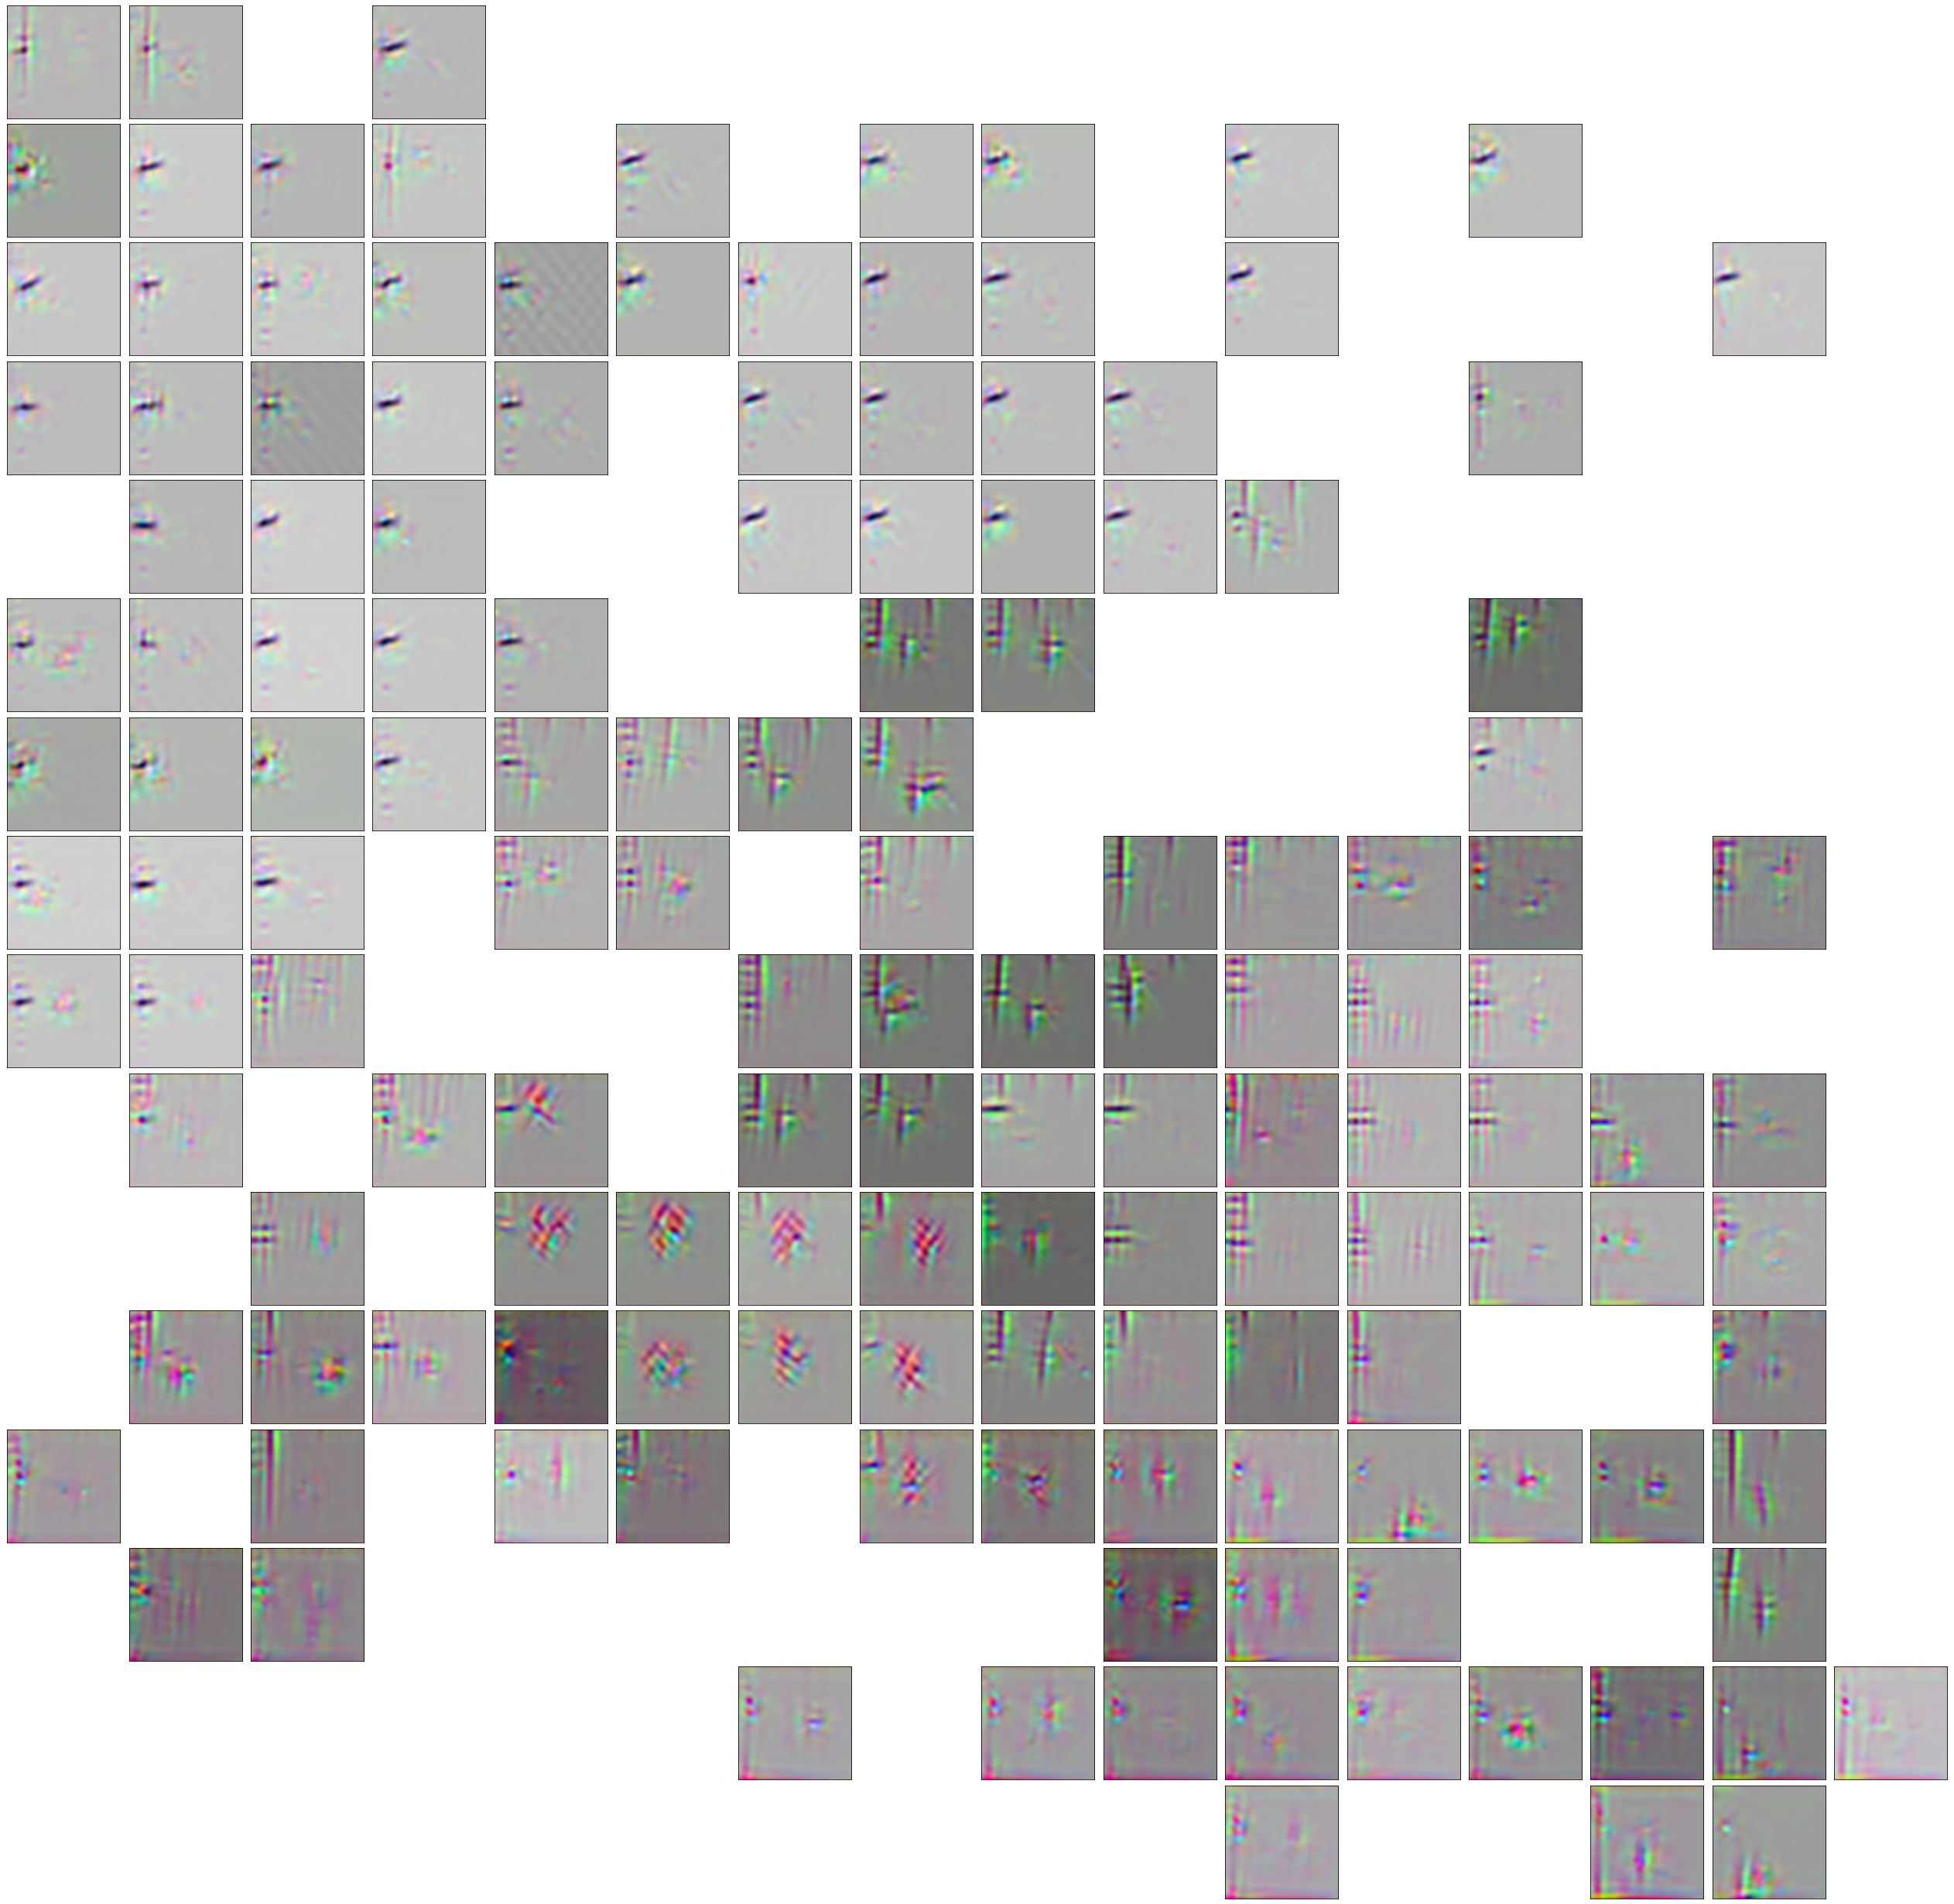

In [12]:
fig, axs = plt.subplots(16,16, figsize=(45,45))


meis, id_used = ((MEI*RecordingInterfaceFP.Units) & mei_key & dict(data_key_original="3783003058075", fp_proc_method=11)).fetch("mei","unit_id_original", download_path="/data/fetched_from_attach", order_by="unit_id_original", )
meis = np.stack([torch.load(i).detach().cpu().numpy().squeeze() for i in meis])
all_meis = np.ones((256,3, 186,186))
all_ids = np.arange(1,257)
idx_filter = np.isin(all_ids, id_used)
all_meis[idx_filter] = meis

for i, ax in enumerate(axs.ravel()):
    if idx_filter[i]:
        #ax.imshow(all_meis[i] - meis.mean(0), cmap="gray", vmin=-1.5, vmax=1.5)
        ax.imshow(fix_mei(all_meis[i,:,20:-20,20:-20]))
        ax.set(xticks=[],yticks=[])

    else:
        ax.axis("off")

plt.subplots_adjust(
                    wspace=0.05, 
                    hspace=0.05)